Henceforth, what I refer to as states here are going to be win, loss, or draw.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import fig_text

### Collect data

Run the script `collect_data.py` to save the CSV data scraped from understat in your current directory. 

In [6]:
##CONSTANTS AND PARAMS
df = pd.read_csv("premier_league_20_21_shots.csv") ##our scraped shots data
color_dict = {0: 'red', 1:'dodgerblue', 2: 'tan'} ##red for loss, blue for win, tan for draw

N_MATCHES = 15 ##minimum matches played by all teams
FINAL_MINUTE = 98 ##assume limit for all matches since we don't have ending time

teams = sorted(df.h_team.unique(), reverse=True)

image_dict = {'Wolverhampton Wanderers': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Wolverhampton_Wanderers.png',
              'West Ham': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\West_Ham_United.png',
              'West Bromwich Albion': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\West_Brom.png',
              'Tottenham': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Tottenham_Hotspur.png',
              'Southampton': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Southampton_FC.png',
              'Sheffield United': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Sheffield_United.png',
              'Newcastle United': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Newcastle_United.png',
              'Manchester United': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Manchester_United.png',
              'Manchester City': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Manchester_City.png',
              'Liverpool': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Liverpool_FC.png',
              'Leicester': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Leicester_City.png',
              'Leeds': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Leeds.png',
              'Fulham': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Fulham.png',
              'Everton': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Everton_FC.png',
              'Crystal Palace': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Crystal_Palace.png',
              'Chelsea': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Chelsea_FC.png',
              'Burnley': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Burnley_FC.png',
              'Brighton': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Brighton_&_Hove_Albion.png',
              'Aston Villa': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Aston_Villa.png',
              'Arsenal': 'C:\\repository\\football_utils\\Football Top 5 Leagues Team Logos\\logos\\Premier League\\Arsenal_FC.png'
              } ##paths to team logos scraped from transfermarkt

### Plotting stuff

In [7]:
def imscatter(x, y, image, ax=None, zoom=1): ##https://stackoverflow.com/a/35651933/10949324 function to plot logos on plots
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


def create_bounds(team, df):
    """Takes a team_name and the full shots dataframe and returns a list of dictionaries where each dictionary is all the states in a match (W/L/D)
    """
    
    df = df.query("h_team == @team | a_team == @team")
    df = df.sort_values(['date', 'minute'])
    df['team'] = np.where(df['h_a']=='h', df['h_team'], df['a_team'])
    match_ids = sorted(df.match_id.unique())

    matches_phases = []
    for match_id in match_ids[:N_MATCHES]:
        
        tdf = df.query("match_id == @match_id")
        HOME = True if tdf['h_team'].unique()[0] == team else False
        indices = np.where(((tdf['result'] == 'Goal') | (tdf['result'] == 'OwnGoal')), True, False)
        tdf = tdf[indices]

        tdf['a_score'] = np.zeros(len(tdf))
        tdf['h_score'] = np.zeros(len(tdf))

        for i in tdf.index:
            
            if tdf.loc[i, 'result'] == 'Goal':
                
                if tdf.loc[i, 'team'] == tdf.loc[i, 'h_team']:
                    tdf.loc[i:, 'h_score'] = tdf.loc[i, 'h_score']+1
                    
                elif tdf.loc[i, 'team'] == tdf.loc[i, 'a_team']:
                        tdf.loc[i:, 'a_score'] = tdf.loc[i, 'a_score']+1

                    
            elif tdf.loc[i, 'result'] == 'OwnGoal':
                
                if tdf.loc[i, 'team'] == tdf.loc[i, 'h_team']:
                    tdf.loc[i:, 'a_score'] = tdf.loc[i, 'a_score']+1
                    
                elif tdf.loc[i, 'team'] == tdf.loc[i, 'a_team']:
                        tdf.loc[i:, 'h_score'] = tdf.loc[i, 'h_score']+1

        tdf['h_state'] = np.where(tdf["h_score"]==tdf["a_score"], 2, np.where(tdf["h_score"]>tdf["a_score"], 1, 0)) ##encode W,L,D as 1,0,2 respectively      
        tdf['a_state'] = tdf['h_state'].map({0:1, 1:0, 2:2}) ##invert for away team
        mins = tdf.minute.to_list() + [FINAL_MINUTE] 

        if HOME:
            team_col = 'h_state'; other_team_col = 'a_state'
        else:
            team_col = 'a_state'; other_team_col = 'h_state'

        match_phases_dict = {}
        match_phases_dict[(0, mins[0])] = 2 ##2 is code for draw
        for start, end, state in zip(mins[:-1], mins[1:], tdf[team_col]):
            match_phases_dict[(start, end)] = state
        matches_phases.append(match_phases_dict)    

    return matches_phases
    

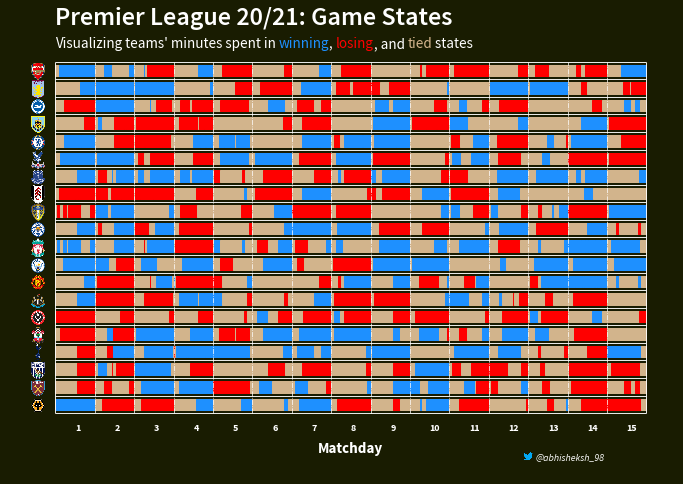

In [9]:
plt.style.use('custom_viz_dark') ##custom stylesheet to set the figure background and fonts 

fig, ax = plt.subplots(figsize=(12,8))
ax.set_axis_off()
fig.text(0.18, 0.91, "Premier League 20/21: Game States", fontweight='demibold', fontsize=26, ha='left')
fig_text(x=0.18, y= 0.865, s= "Visualizing teams' minutes spent in <winning>, <losing>, and <tied> states",
         highlight_colors=[color_dict[1], color_dict[0], color_dict[2]], fontsize=15)

ax.vlines(x=range(1,N_MATCHES), ymin=0, ymax=20, linestyle='-.', alpha=.9, zorder=10, lw=0.8, color='white')
ax.vlines(x=[0, N_MATCHES], ymin=0, ymax=20, color='white', lw=0.9)
ax.hlines(y=range(21), xmin=0, xmax=N_MATCHES, lw=0.9, color='white')

for y_num, team in enumerate(teams):
    #ax.text(-1, y_num, team)
    imscatter(-.45, y_num+.4, image_dict[team], ax, .1)
    team_data = create_bounds(team, df)
    for x_num, match_dict in enumerate(team_data):
        y1 = y_num+0.17; y2 = y_num+0.83;
        for key, value in match_dict.items():
            
            x1 = key[0]/FINAL_MINUTE + x_num; x2 = key[1]/FINAL_MINUTE + x_num
            ax.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color=color_dict[value])

## custom X-axis labels and ticks
for i in range(0, N_MATCHES):
    ax.text(i+.5, -1, i+1, fontweight='bold')
ax.text(N_MATCHES/2, -2, 'Matchday', ha='center', va='center', fontweight='bold', fontsize=15)

##credits
imscatter(12, -2.5, r"C:\Users\sharm\Desktop\twitter_icon.png", ax, .05)
ax.text(12.2, -2.5, "@abhisheksh_98", va='center', ha='left', fontstyle='italic', fontsize=10);
##fig.savefig('temp', dpi=220)